In [ ]:
# default_exp timeseries

# timeseries

> Módulo com implementação de algoritmos para detecção de **anomalias em series temporais**.

In [ ]:
#export
import numpy as np
import pandas as pd

from pyanomaly.stats import MAD, Tukey #, ESD

In [ ]:
#export
def factory_atype(atype='mad'):
    if atype == 'mad':
        return MAD()
    elif atype == 'tukey':
        return Tukey
    else:
        raise ValueError('Algoritmo de detecção de anomalia não implementado - \"{}\"'.format(atype))

## Moving Average

In [ ]:
#export
def moving_average(ts, window=12, atype='mad'):
    ''' 
    Detecção de anomalias com base no Moving Average da serie tempora(ts).
    ts = numpy array      - serie temporal
    window_size = [2..n]  - Tamanho da janela
    atype = ['mad', 'tukey'] - algoritmo para detecção de anomalias'''
    ts_ma = pd.Series(ts).rolling(window).mean()
    m = factory_atype(atype)
    m.fit(ts_ma)
    return m.predict(ts_ma)

In [ ]:
#export
def moving_average_score(ts, window=12,  atype='mad'):
    '''
    Detecção de anomalias com base no Moving Average da serie tempora(ts).
    ts = numpy array      - serie temporal
    window_size = [2..n]  - Tamanho da janela
    atype = ['mad', 'tukey'] - algoritmo para detecção de anomalias'''
    ts_ma = pd.Series(ts).rolling(window).mean()
    m = factory_atype(atype)
    m.fit(ts_ma)
    return m.decision_function(ts_ma)

## Twitter

O algoritmo popularizado pelo Twitter é um conjunto como o **Seasonal Hybrid ESD (S-H-ESD)**  que funciona em cima do **Generalized ESD test** para detecção de anomalias. S-H-ESD pode ser utilizado tanto para detecção local ou global de anomalias. O método envolvi decompor a serie temporal e utilizar métodos robustos para detecção de anomalias(MAD).

Já existe a implementação fornecida pelo **Twitter** na linguagem **R**, a seguir temos a implementação do algoritmo feita em Python.

Artigo: https://arxiv.org/pdf/1704.07706.pdf

In [ ]:
#export
from statsmodels.tsa.seasonal import STL

def twitter(x, period=None):
    ''' 
        Retorna os index dos valores que são anomalias
        input precisa ser um Serie com index temporal'''
    # filtrando o componente seasonal
    if period is not None:
        stl = STL(x, period=period)
    else:
        stl = STL(x)
    
    res = stl.fit()
    # calculamos o residuo
    residuo = x - np.nanmedian(x) - res.seasonal
    # Procuramos outliers com MAD
    mad = MAD()
    mad.fit(residuo)
    index = mad.predict(residuo).index
    return x.loc[index]

In [ ]:
#export
from statsmodels.tsa.seasonal import STL

def twitter_score(x, period=None):
    ''' 
        Retorna os index dos valores que são anomalias
        input precisa ser um Serie com index temporal'''
    # filtrando o componente seasonal
    if period is not None:
        stl = STL(x, period=period)
    else:
        stl = STL(x)
    res = stl.fit()
    # calculamos o residuo
    residuo = x - np.nanmedian(x) - res.seasonal
    # Procuramos outliers com MAD
    mad = MAD()
    mad.fit(residuo)
    return mad.decision_function(residuo)

# Teste

In [ ]:
df = pd.read_csv('./dados/rec-center-hourly.csv', parse_dates=[0])
df.set_index('datetime', inplace=True)
df.head()

,kw_energy_consumption
datetime,
2010-07-02 00:00:00,21.2
2010-07-02 01:00:00,16.4
2010-07-02 02:00:00,4.7
2010-07-02 03:00:00,4.7
2010-07-02 04:00:00,4.6


In [ ]:
twitter(df['kw_energy_consumption'])

datetime
2010-07-03 19:00:00     5.3
2010-07-04 06:00:00     5.2
2010-07-04 07:00:00     5.6
2010-07-04 18:00:00     9.9
2010-07-04 19:00:00     5.4
                       ... 
2010-12-26 09:00:00    31.9
2010-12-26 10:00:00    27.2
2010-12-26 15:00:00    20.1
2010-12-26 16:00:00     6.0
2010-12-26 17:00:00     5.5
Name: kw_energy_consumption, Length: 161, dtype: float64

In [ ]:
score = twitter_score(df['kw_energy_consumption'])
day_sum = score.resample('D').sum()
day_sum

datetime
2010-07-02    23.352489
2010-07-03    22.845017
2010-07-04    35.464683
2010-07-05    19.130263
2010-07-06     7.774466
                ...    
2010-12-27    17.774254
2010-12-28    17.123284
2010-12-29    20.390904
2010-12-30    28.883247
2010-12-31    25.459017
Freq: D, Length: 183, dtype: float64

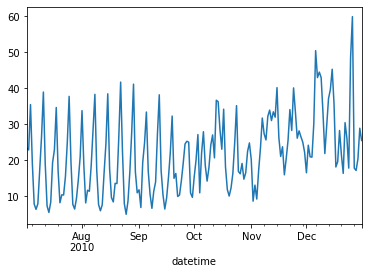

In [ ]:
day_sum.plot();